In [3]:
# !pip install numpy==1.21.6
# !pip install matplotlib==3.5.3
# !pip install pandas==1.3.5
# !pip install scipy==1.7.3
# !pip install plotly==5.18.0
# !pip install scikit-learn==1.0.1
# !pip install tensorflow==2.11.0
# !pip install sciann==0.7.0.1

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io 
import time
import random

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

ModuleNotFoundError: No module named 'numpy'

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
#Model specifications

v0 = 2.; # Velocity at the origin of the model
vergrad = 0.5; # Vertical gradient
horgrad = 0.; # Horizontal gradient

zmin = 0.; zmax = 2.; deltaz = 0.02
xmin = 0.; xmax = 2.; deltax = 0.02

# Point-source location
sz = 1.0; sx = 1.0

# Number of training points
num_tr_pts = 2500

In [ ]:
# Creating grid, calculating refrence traveltimes, 
# and prepare list of grid points for training (X_star)

z = np.arange(zmin, zmax + deltaz, deltaz)
nz = z.size

x = np.arange(xmin, xmax + deltax, deltax)
nx = x.size

# Gradient layer
Z, X = np.meshgrid(z, x , indexing='ij')

# Define velocity model with two layers
velmodel = np.zeros_like(Z)  # Initialize velocity model array
velmodel[Z <= 1] = 3  # Set velocity for the first layer (depth <= 1)
velmodel[Z > 1] = 5   # Set velocity for the second layer (depth > 1)

# # Preparing velocity model
vs = v0 + vergrad * sz + horgrad * sx # Velocity at the source location
# velmodel = vs + vergrad * (Z - sx) + horgrad * (X - sz)

# Traveltime solution
if vergrad==0 and horgrad==0: 
  # For homogeneous velocity model
  T_data = np.sqrt((Z-sz)**2 + (X-sx)**2)/v0;
else: 
  # For velocity gradient model
  T_data = np.arccosh(1.0 + 0.5 * (1.0/velmodel) * (1/vs) * (vergrad ** 2 + horgrad ** 2) * ((X-sx) ** 2 + (Z-sz) ** 2)) / np.sqrt(vergrad ** 2 + horgrad ** 2)

X_star = [Z.reshape(-1, 1), X.reshape(-1,1)] # Grid points for prediction 

selected_pts = np.random.choice(np.arange(Z.size), num_tr_pts, replace=False)
Zf = Z.reshape(-1, 1)[selected_pts]
Zf = np.append(Zf, sz)
Xf = X.reshape(-1, 1)[selected_pts]
Xf = np.append(Xf, sx)

X_starf = [Zf.reshape(-1, 1), Xf.reshape(-1, 1)] # Grid points for training

In [ ]:
print(velmodel)

[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]


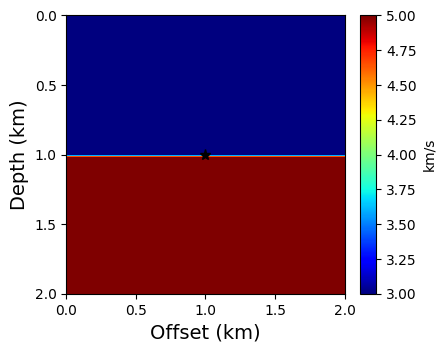

In [ ]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4, 4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin, xmax, zmax, zmin], aspect=1, cmap="jet")

ax.plot(sx, sz, 'k*', markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("./figs/vofz/velmodel.pdf", format='pdf', bbox_inches="tight")

In [ ]:
# Analytical solution for the known traveltime part
vel = velmodel[int(round(sz/deltaz)),int(round(sx/deltax))] # Velocity at the source location

T0 = np.sqrt((Z-sz)**2 + (X-sx)**2)/vel; 

px0 = np.divide(X-sx, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-sz, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)

In [ ]:
# Find source location id in X_star

TOLX = 1e-6
TOLZ = 1e-6

sids,_ = np.where(np.logical_and(np.abs(X_starf[0]-sz)<TOLZ , np.abs(X_starf[1]-sx)<TOLX))

print(sids)
print(sids.shape)
print(X_starf[0][sids,0])
print(X_starf[1][sids,0])

[2500]
(1,)
[1.]
[1.]


In [ ]:
# Preparing the Sciann model object

K.clear_session() 

layers = [20]*10

# Appending source values
velmodelf = velmodel.reshape(-1,1)[selected_pts]
velmodelf = np.append(velmodelf,vs)

px0f = px0.reshape(-1,1)[selected_pts]
px0f = np.append(px0f,0.)

pz0f = pz0.reshape(-1,1)[selected_pts]
pz0f = np.append(pz0f,0.)

T0f = T0.reshape(-1,1)[selected_pts]
T0f = np.append(T0f,0.)

xt = Variable("xt",dtype='float64')
zt = Variable("zt",dtype='float64')
vt = Variable("vt",dtype='float64')
px0t = Variable("px0t",dtype='float64')
pz0t = Variable("pz0t",dtype='float64')
T0t = Variable("T0t",dtype='float64')

tau = Functional("tau", [zt, xt], layers, 'l-atan')

# Loss function based on the factored isotropic eikonal equation
L = (T0t*diff(tau, xt) + tau*px0t)**2 + (T0t*diff(tau, zt) + tau*pz0t)**2 - 1.0/vt**2

targets = [tau, PDE(10*L), (1-sign(tau*T0t))*abs(tau*T0t)]
target_vals = [(sids, np.ones(sids.shape).reshape(-1,1)), 'zeros', 'zeros']

model = SciModel(
    [zt, xt, vt, pz0t, px0t, T0t], 
    targets,
    optimizer='Adam'
)

In [ ]:
#Model training

start_time = time.time()
hist = model.train(
       X_starf + [velmodelf,pz0f,px0f,T0f],
       target_vals,
       batch_size = X_starf[0].size,
       # adaptive_weights={'method': 'NTK', 'freq': 100, 'epochs': 1000},
       epochs = 10000,
       learning_rate = 0.0002,
       verbose=0
       )
elapsed = time.time() - start_time
print('Training time: %.2f seconds' %(elapsed))


Total samples: 2501 
Batch size: 2501 
Total batches: 1 

Training time: 1320.43 seconds


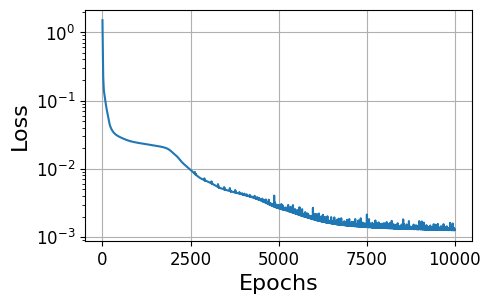

In [ ]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.semilogy(hist.history['loss'])

ax.set_xlabel('Epochs',fontsize=16)

plt.xticks(fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(2500))

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12);
plt.grid()

In [ ]:
# Predicting traveltime solution from the trained model

L_pred = L.eval(model, X_star + [velmodel,pz0,px0,T0])
tau_pred = tau.eval(model, X_star + [velmodel,pz0,px0,T0])
tau_pred = tau_pred.reshape(Z.shape)

T_pred = tau_pred*T0

print('Time at source: %.4f'%(tau_pred[int(round(sz/deltaz)),int(round(sx/deltax))]))

Time at source: 1.0029


In [ ]:
np.save('../experiences/pinn_output/2segs.npy', T_pred)

In [ ]:
T_fsm = np.load("../experiences/fsm_output/2layers.npy")

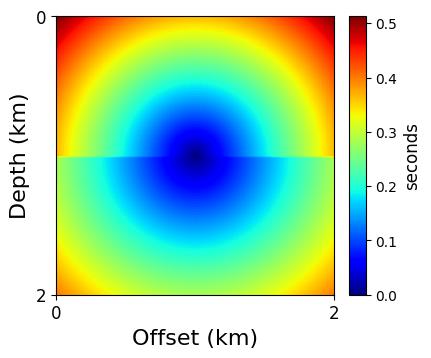

In [ ]:
# Plot the computed tau

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fsm-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

plt.xlabel('Offset (km)', fontsize=16)
plt.xticks(fontsize=12)

plt.ylabel('Depth (km)', fontsize=16)
plt.yticks(fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=12)
cbar.ax.tick_params(labelsize=10)

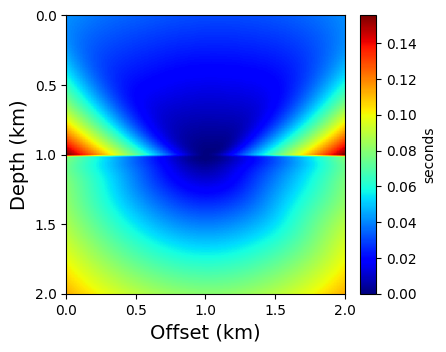

In [ ]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("./figs/vofz/pinnerror.pdf", format='pdf', bbox_inches="tight")

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

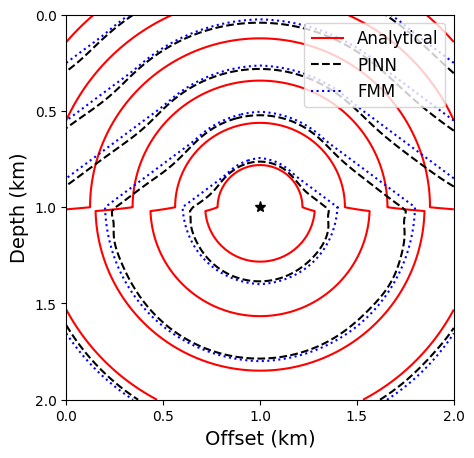

In [ ]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_pred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fsm, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', "FMM"],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# plt.savefig("./figs/vofz/contours.pdf", format='pdf', bbox_inches="tight")